## Detection of available parking spots from parking lot camera images

This notebook specifies the approach and demonstrates working of our solution for the above problem statement.

**Team : Scientific Harmony**

#### Code snippets in this notebook follow the below flow -

1. [Configuration for Mask R-CNN model and helper function to filter object detection result](#section_1)
2. [Initialize variables and paths](#section_2)
3. [Creating model and loading model weights](#section_3)
4. [Identifying parking spaces in the parking lot](#section_4)
5. [Detecting empty parking spots](#section_5)

### <a id='section_1'>1. Configuration for Mask R-CNN model and helper function to filter object detection result. </a>

In [1]:
import os
import numpy as np
import random
import cv2
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import mrcnn.config
from mrcnn import utils, visualize
from mrcnn.model import MaskRCNN
from pathlib import Path

Using TensorFlow backend.


We will be using Mask R-CNN model pre-trained on the MS COCO dataset.

In [3]:
#  Configuration that will be used by Mask R-CNN library

class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes + one background class
    DETECTION_MIN_CONFIDENCE = 0.6
    
    
# Filter the result of Mask R-CNN to only obtain bounding boxes and class names of objects identified as cars

def getCarBoxes(boxes,class_ids):
    car_boxes = []
    
    # class_id 3/8 corresponds to car/truck objects as per COCO dataset
    for i,box in enumerate(boxes):
        if class_ids[i] in [3,8]:
            car_boxes.append(boxes)
            
    return np.array(car_boxes)

### <a id='section_2'>2. Initialize variables and paths</a>



In [4]:
# Root directory of the project
ROOT_DIR = "."

# Local path for logs and trained model.One of the best practices and useful while training the model . 
# Will not be used in this demonstration
MODEL_DIR = os.path.join(ROOT_DIR,"logs")


# Path for saving trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR,"mask_rcnn_coco.h5")


# Downloading weights of pre-trained model for COCO dataset from the release 
# Executed for the first time when to store the model weights in this repo

# if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)
        

### <a id='section_3'>3. Creating model and loading model weights</a>


In [5]:
# Directory of images to run detection on
IMAGE_DIR = "images"


# Create a Mask R-CNN model in inference mode
model = MaskRCNN(mode='inference', config=MaskRCNNConfig(),model_dir=MODEL_DIR)


# Load pre-trained model, this will load weights of model trained on COCO dataset
%time model.load_weights(COCO_MODEL_PATH,by_name=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Wall time: 14 s


For each object detected in the image fed as input, the model classifies it and returns class ID, which is an integer value identifying each class.

In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the person class, use: class_names.index('person')

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### <a id='section_4'>4. Identifying parking spaces in the parking lot</a>



The bouding box for each car identified is a parking parking spot.

These coordinates captured by the system in real time will be used for comparing bounding boxes of subsequent images captured in the system to find if the identified cars's bounding box overlap with the reference spots.

If the overlap is above a threshold, the space is occupied, otherwise it is **available** which is our aim.

In [7]:
# Location of parking spaces
parked_car_boxes = None

### Run instance detection

In [8]:
# Load a random image from images folder
file_names = next(os.walk(IMAGE_DIR))[2]         

In [9]:
file_names

['1_2015-11-16_1025_overcast.jpg',
 '2015-11-12_0814_sunny.jpg',
 '2015-11-16_0722_overcast.jpg',
 '2015-11-16_0752.jpg',
 '2015-11-16_0822.jpg',
 '2015-11-16_0853.jpg',
 '2015-11-16_0923.jpg',
 '2015-11-16_0954.jpg',
 '2015-11-16_1025.jpg',
 '2015-11-16_1056.jpg',
 '2015-11-16_1127.jpg',
 '2015-11-16_1158.jpg',
 '2015-11-16_1229.jpg',
 '2015-11-16_1300.jpg',
 '2015-11-16_1331.jpg',
 '2015-11-16_1402.jpg',
 '2015-11-16_1433.jpg',
 '2015-11-16_1504.jpg',
 '2015-11-16_1535.jpg',
 '2015-11-16_1607.jpg',
 '2015-11-16_1637.jpg',
 '2015-11-16_1708.jpg',
 '2015-11-16_1734.jpg',
 '2015-11-21_1603_rainy.jpg']

#### Identifying for Sunny conditions

In [14]:
# choose the first 2 images from a sequence of file_names 
# First image is the reference image of completely occupied parking area. It is used for finding all parking spots

image1 = skimage.io.imread(os.path.join(IMAGE_DIR,file_names[0]))
image2 = skimage.io.imread(os.path.join(IMAGE_DIR,file_names[1]))


In [11]:
# run detection
# runs the detection pipeline and returns a list of dictionaries, one dict per image.

%time result1 = model.detect([image1])    


Wall time: 29.8 s


In [12]:
%time result2 = model.detect([image2])    

Wall time: 16.8 s


In [13]:
r1 = result1[0]
r2 = result2[0]


Visualize the result of instance segmentation 

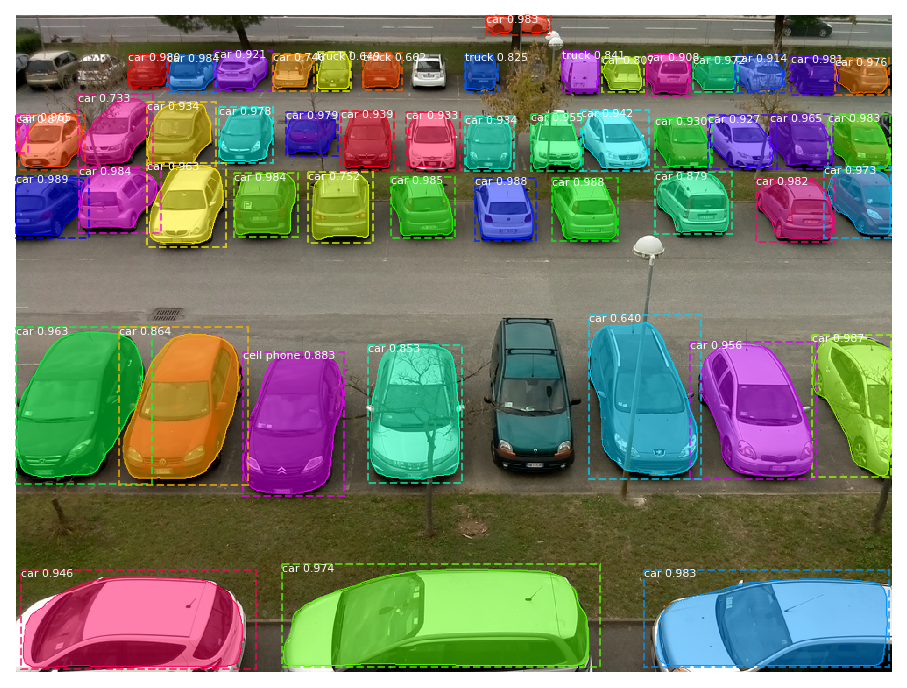

In [15]:
visualize.display_instances(image1,r1['rois'],r1['masks'], r1['class_ids'], class_names, r1['scores'])

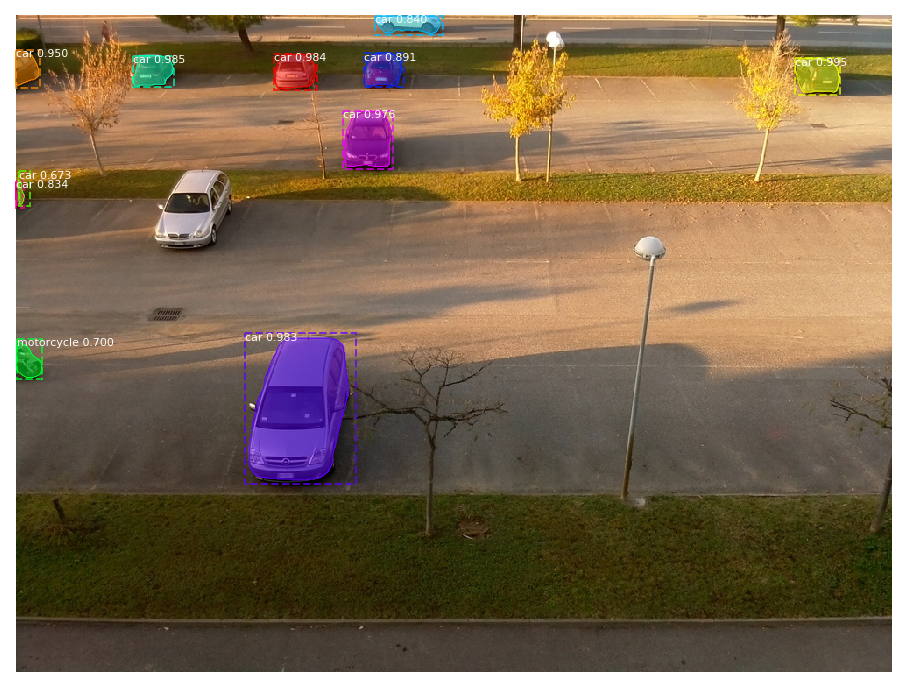

In [16]:
visualize.display_instances(image2,r2['rois'], r2['masks'], r2['class_ids'], class_names, r2['scores'])

In [17]:
# Filter the results to only get identified cars' bounding boxes

car_boxes1 = getCarBoxes(r1['rois'],r1['class_ids'])
car_boxes2 = getCarBoxes(r2['rois'],r2['class_ids'])

# car_boxes1 and car_boxes2 is an array of length of no. of cars identified with each row having set of 
# 4 coordinates y1, x1, y2, x2 ; points 1 and 2 are opposite vertices of the bounding box.

In [18]:
car_boxes1[0].shape

(51, 4)

#### The first image has the parking lot occupied in full capacity. Hence, treating the bounding boxes for these cars as parking lot spaces in subsequent images to identify if these spaces are occupied by cars.

In [19]:
parking_spaces = car_boxes1[0]

# computinig center locations of each spot
center_locs = []

for spot_coords in parking_spaces:
    center_locs.append([int((spot_coords[1]+spot_coords[3])/2), int((spot_coords[0]+spot_coords[2])/2)])


centers = np.array(center_locs)
    

In [20]:
centers.shape

(51, 2)

In [21]:
# Draw each box on the frame

for i,box in enumerate(parking_spaces):
    y1, x1, y2, x2 = box
    cv2.rectangle(image1, (x1, y1), (x2, y2),(0,0,255),2)
    cv2.circle(image1,(centers[i][0],centers[i][1]),2,(0,0,255),2)

In [22]:
# show the image on screen

cv2.imshow('image', image1)
cv2.waitKey(0)
cv2.destroyAllWindows()


The above snippet gives the following output for identifying all the parking spots

<img src='result_images/all_parking_spots.png'>

Bounding box and center location for an occupied spot is displayed in red. Since the location of a parking is the location of the parked car, bounding boxes and center location of all the cars are red.

In [85]:
parking_spaces.shape

(51, 4)

In [86]:
car_boxes2.shape

(1, 6, 4)

### <a id='section_5'>5. Detecting empty parking spots</a>



In [24]:
# How much car overlaps with the bounding boxes of parking spaces

overlaps = mrcnn.utils.compute_overlaps(car_boxes2[0],parking_spaces)

In [25]:
overlaps.shape

(11, 51)

In [26]:
overlap_prob = overlaps.sum(axis=0)

In [27]:
for i,box in enumerate(parking_spaces):
    y1, x1, y2, x2 = box
    
    if overlap_prob[i] >= 0.5:
        occupancy_status = (0,0,255)
    
    else:
        occupancy_status = (0,255,0)
    cv2.rectangle(image2,(x1,y1), (x2,y2) , occupancy_status ,1)
    cv2.circle(image2,(centers[i][0],centers[i][1]),2,occupancy_status,2)
        
    

In [28]:
cv2.imshow('image', image2)
cv2.waitKey(0)
cv2.destroyAllWindows()

The above snippet give the following output for identifying empty parking spots in an image captured on a **sunny day**
    
<img src='result_images/detect_empty_space_sunny.png'>

Bounding box and center location for an **empty spot** is displayed in **green**. 